In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

USE_DRIVE = False
if USE_DRIVE:
    from google.colab import drive

    drive.mount('/content/gdrive')
    ROOT_DRIVE = '/content/gdrive/MyDrive/'
    DRIVE_FOLDER_PATH = os.path.join(ROOT_DRIVE, 'HuBMAP')
    IMAGES_PATH = os.path.join(DRIVE_FOLDER_PATH, 'hubmap-256x256', 'train')
    MASKS_PATH = os.path.join(DRIVE_FOLDER_PATH, 'hubmap-256x256', 'masks')
else:
    IMAGES_PATH = os.path.join('data', '256x256', 'train')
    MASKS_PATH = os.path.join('data', '256x256', 'masks')

# Data analysis and exploration

## Images

In [3]:
from easyimages import EasyImageList

image_list = EasyImageList.from_folder(IMAGES_PATH)
image_list.html(sample=51, size=256)

In [4]:
# TODO: Consideration on the complete images

## Mask

Total number of training images is 3676.
Total number of glomeruli is 2680.
Average number of glomeruli per image is 0.7290533188248096.
Glomeruli spatial information:


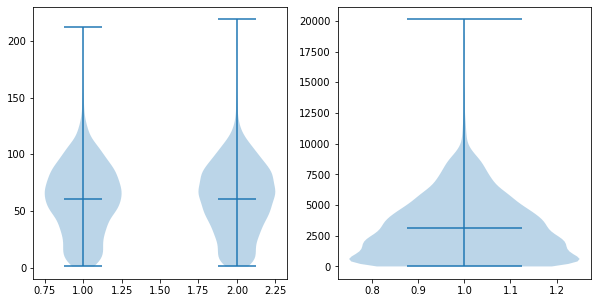

Glomeruli represents the 0.034737924237505526% of the total number of pixels.


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import pandas as pd

num_glomeruli_per_image = []

glomeruli_filenames = []
glomeruli_widths = []
glomeruli_heights = []
glomeruli_areas = []

filenames = os.listdir(MASKS_PATH)

for filename in filenames:
    mask = cv2.imread(os.path.join(MASKS_PATH, filename), 0)
    # output is (num_labels, labelled image, stats, centroids)
    # stats is [[leftmost x coord, topmost y coord, width, height, area] for each label]
    output = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    # Update number of glomeruli found
    num_glomeruli_per_image.append(output[0] - 1)   
    for stat in output[2]:
        if stat[2] == stat[3] == 256:
            continue
        glomeruli_filenames.append(filename)
        glomeruli_widths.append(stat[2])
        glomeruli_heights.append(stat[3])
        glomeruli_areas.append(stat[4])


print(f'Total number of training images is {len(filenames)}.')
print(f'Total number of glomeruli is {len(glomeruli_heights)}.')
print(f'Average number of glomeruli per image is {np.mean(num_glomeruli_per_image)}.')

"""
glomeruli_df = pd.DataFrame({'widths': glomeruli_widths,
                            'heights': glomeruli_heights,
                            'areas': glomeruli_areas})
glomeruli_df.describe()
"""

print('Glomeruli spatial information:')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].violinplot(dataset=[glomeruli_widths,
                            glomeruli_heights], 
                   showmeans=True)
axes[1].violinplot(dataset=[glomeruli_areas],
                   showmeans=True)


plt.show()

print(f'Glomeruli represents the {np.sum(glomeruli_areas)/(len(os.listdir(MASKS_PATH))*256*256)}% of the total number of pixels.')

Some interesting images:
- the one with the largest number of glomerulis
- the one containing the smallest area 
- the one containing the largest area
- the one containing the largest width
- the one containing the largest height

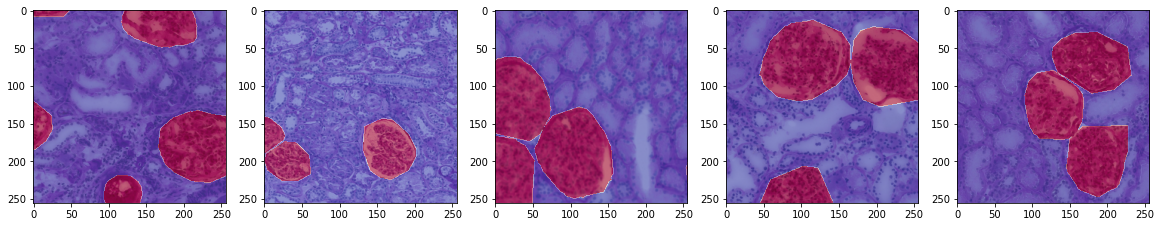

In [6]:
from PIL import Image

from visualization.visualize_data import display_images_and_masks

display_images_and_masks([Image.open(os.path.join(IMAGES_PATH, filenames[np.argmax(num_glomeruli_per_image)])),
                          Image.open(os.path.join(IMAGES_PATH, glomeruli_filenames[np.argmin(glomeruli_areas)])),
                          Image.open(os.path.join(IMAGES_PATH, glomeruli_filenames[np.argmax(glomeruli_areas)])),
                          Image.open(os.path.join(IMAGES_PATH, glomeruli_filenames[np.argmax(glomeruli_widths)])),
                          Image.open(os.path.join(IMAGES_PATH, glomeruli_filenames[np.argmax(glomeruli_heights)]))],
                         [Image.open(os.path.join(MASKS_PATH, filenames[np.argmax(num_glomeruli_per_image)])),
                          Image.open(os.path.join(MASKS_PATH, glomeruli_filenames[np.argmin(glomeruli_areas)])),
                          Image.open(os.path.join(MASKS_PATH, glomeruli_filenames[np.argmax(glomeruli_areas)])),
                          Image.open(os.path.join(MASKS_PATH, glomeruli_filenames[np.argmax(glomeruli_widths)])),
                          Image.open(os.path.join(MASKS_PATH, glomeruli_filenames[np.argmax(glomeruli_heights)]))])


# Baseline and model overfitting

In [7]:
from utils import get_device_colab, set_deterministic_colab

NOT_COLAB = True
if not NOT_COLAB:

    DEVICE = get_device_colab()
else:
    DEVICE = 'cpu'

SEED = 42
set_deterministic_colab(SEED)

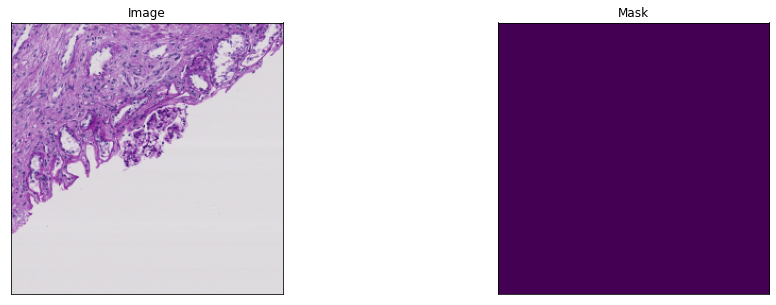

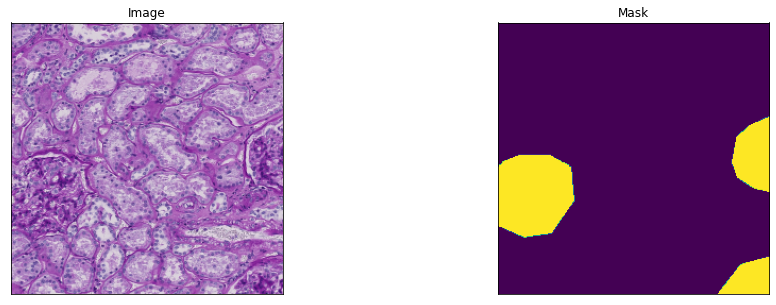

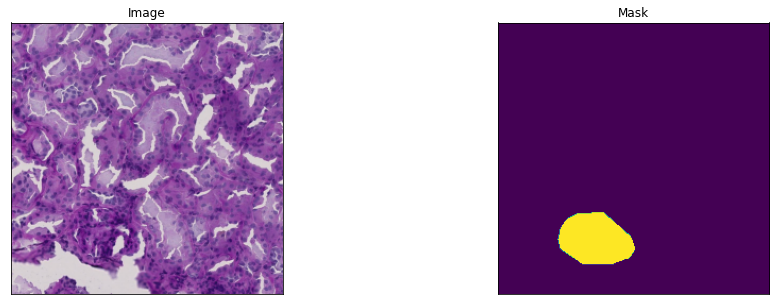

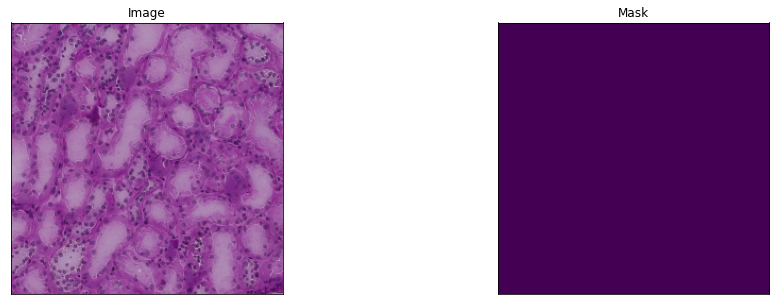

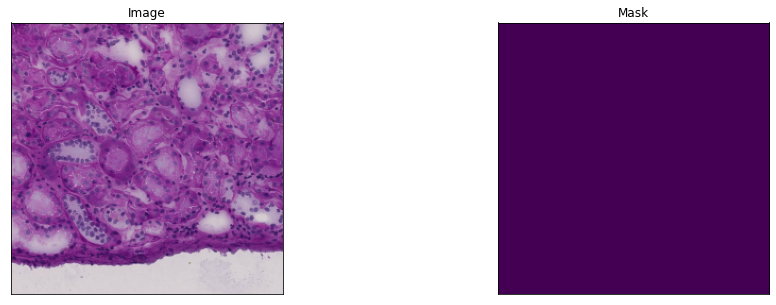

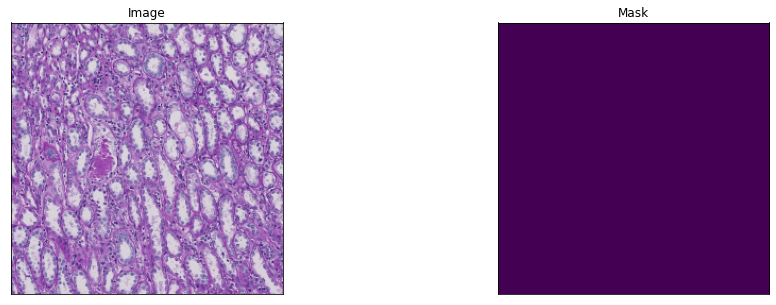

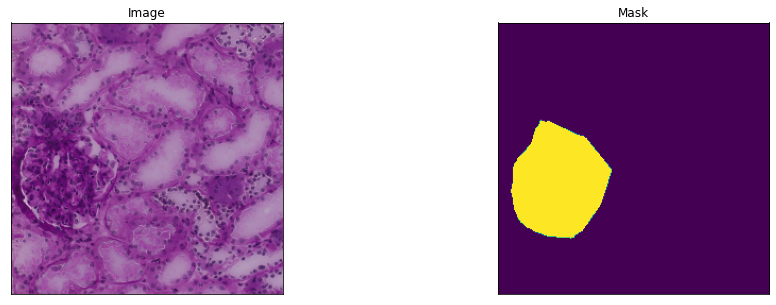

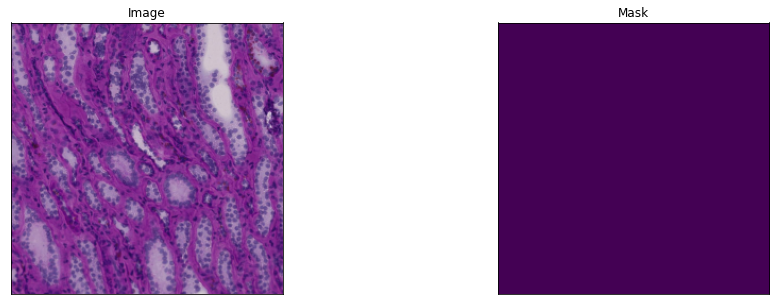

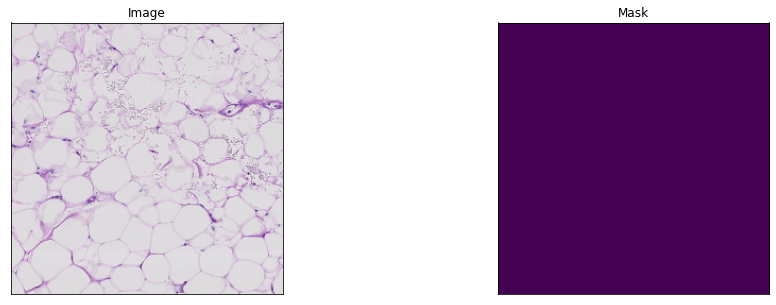

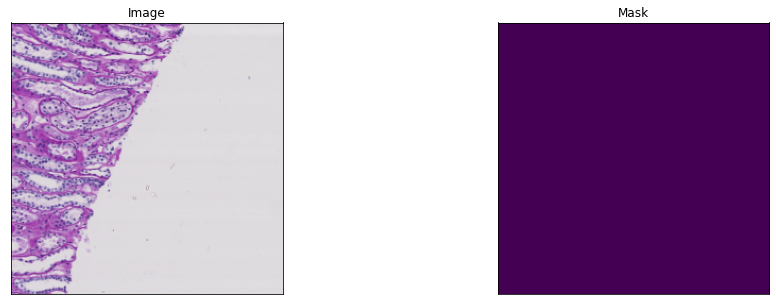

In [8]:
import itertools

from preprocessing.dataset import get_training_validation_sets, denormalize_images, HuBMAPDataset
from preprocessing.augmentation import get_augmentations
from training.loop import Trainer
from training.loss_functions import BinaryDiceLoss
from visualization.visualize_data import visualize

import torch
from torchvision import transforms

# From https://pytorch.org/docs/stable/torchvision/models.html
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_dataset, training_images, validation_dataset, validation_images = get_training_validation_sets(IMAGES_PATH,
                                                                                                        MASKS_PATH,
                                                                                                        0.3, 
                                                                                                        {'train': None,
                                                                                                         'val': None},
                                                                                                        mean,
                                                                                                        std)

for image, mask in itertools.islice(training_dataset, 0, 10):
    visualize(image=denormalize_images(image, mean, std), mask=mask)

In [9]:
from model.pretrained_models import get_unet

model, model_params = get_unet(device=DEVICE, 
                               encoder='mobilenet_v2',
                               depth=1,
                               decoder_channels=[256])
print(model)

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=Fals

In [10]:
model_params

{'input_space': 'RGB',
 'input_range': [0, 1],
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225]}

In [ ]:
criterion = BinaryDiceLoss(logits=False).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

trainer = Trainer(model,
                  0.3,
                  criterion,
                  optimizer,
                  16,
                  DEVICE,
                  "logs",
                  training_dataset,
                  validation_dataset)

stats, eval_stats = trainer.train(1, verbose=True, limit=2)

  0%|          | 0/161 [00:00<?, ?it/s]

Training epoch 1/1:
